## S-Mobile: Predicting Customer Churn
* Team-lead GitLab userid: dbeaudreau
* Group name: Team Nine From Outer Space
* Team member names: Chenxuan Liu, Danielle Beaudreau, Nicholas Feldman, Wan-Ting Hsu, Yijie Shi

## Setup

Please complete this Jupyter notebook by answering the questions in `s-mobile.pdf` on Canvas (week9/). Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML from the Jupyter Notebook file without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the fourth group assignment for MGTA 455 and you will be using git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". git will not decide for you who's change to accept so the team-lead will have to determine which edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings('ignore')
import os
import urllib.request
import zipfile
from tempfile import NamedTemporaryFile as tmpfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from utils import functions as f
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
from sklearn.inspection import permutation_importance, plot_partial_dependence, PartialDependenceDisplay
# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
## load the data - this dataset must NOT be changed
s_mobile = pd.read_pickle("data/s_mobile.pkl")
s_mobile["churn_yes"] = rsm.ifelse(s_mobile["churn"] == "yes", 1, 0)

If you want access to the full 1M row dataset, use the code below to download and use the data. Please do **not** include the 1M row dataset in your repo!

The downside to using the dataset with 1M rows is, of course, that estimation time will increase substantially. I do NOT recommend you use this dataset to select your final model or for tuning hyper parameters. You can, however, use this larger dataset to re-estimate your chosen model and generate profit estimates for the representative sample.

In [3]:
# uncomment to run
url = "https://www.dropbox.com/s/xhiexneeok9gyhs/s_mobile_1M.pkl.zip?dl=1"
file_path, _ = urllib.request.urlretrieve(url)
zip_file = zipfile.ZipFile(file_path, "r")
s_mobile_tmp = zip_file.open(zip_file.namelist()[0])
os.remove(file_path)
s_mobile_1m = pd.read_pickle(s_mobile_tmp)
s_mobile_1m["churn_yes"] = rsm.ifelse(s_mobile_1m["churn"] == "yes", 1, 0)

In [4]:
s_mobile_1m

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,smartphone,highcreditr,mcycle,car,travel,region,occupation,training,representative,churn_yes
0,U88927415,no,-1,-8,31,118,1,0,0,38,...,yes,no,no,no,no,SW,other,0.0,0,0
1,U94655060,no,0,-2,87,412,104,0,0,10,...,yes,no,no,no,yes,CS,student,1.0,0,0
2,U22910834,no,1,23,138,1252,0,3,0,19,...,yes,no,no,no,no,SE,student,1.0,0,0
3,U55939985,no,-1,-15,58,69,42,3,0,8,...,yes,yes,no,no,no,NE,other,NaN,1,0
4,U74897690,no,-9,-20,117,1002,175,4,0,11,...,yes,no,no,no,no,SE,other,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004995,U63357590,no,2,34,54,778,115,1,1,7,...,yes,no,no,no,no,NW,other,0.0,0,0
1004996,U10548621,no,-5,-20,31,176,40,3,0,35,...,no,no,no,no,no,CS,retired,1.0,0,0
1004997,U61718563,no,-3,-2,45,1731,105,0,0,30,...,yes,no,no,no,no,SW,other,1.0,0,0
1004998,U79998923,no,73,46,108,1156,144,18,0,18,...,yes,no,no,no,no,CS,other,0.0,0,0


In [5]:
# show dataset description
rsm.describe(s_mobile)

## S-mobile

Dataset used to investigate opportunities to decrease customer churn at S-mobile. The sample consists of three parts:

1. A training sample with 27,300 observations and a 50% churn rate ("training == 1")
2. A test sample with 11,700 observations and a 50% churn rate ("training == 0")
3. A representative sample with 30,000 observations and a churn rate of 2%, i.e., the actual monthly churn rate for S-mobile ("is.na(training)" or "representative == 1")

## Variables

* customer: Customer ID
* churn: Did consumer churn in the last 30 days? (yes or no)
* changer: % change in revenue over the most recent 4 month period
* changem: % change in minutes of use over the most recent 4 month period
* revenue: Mean monthly revenue in SGD
* mou: Mean monthly minutes of use
* overage: Mean monthly overage minutes
* roam: Mean number of roaming calls
* conference: Mean number of conference calls
* months: # of months the customer has had service with S-Mobile
* uniqsubs: Number of individuals listed on the customer account
* custcare: Mean number of calls to customer care 
* retcalls: Number of calls by the customer to the retention team
* dropvce: Mean number of dropped voice calls 
* eqpdays: Number of days customer has owned current handset
* refurb: Handset is refurbished (no or yes)
* smartphone: Handset is a smartphone (no or yes)
* creditr: High credit rating as opposed to medium or low (no or yes)
* mcycle: Subscriber owns a motorcycle (no or yes)
* car: Subscriber owns a car (no or yes)
* travel: Subscriber has traveled internationally (no or yes)
* region: Regions delineated by the 5 Community Development Council Districts (e.g., CS is Central Singapore)
* occupation: Categorical variable with 4 occupation levels (professional, student, retired, or other)
* training: 1 for training sample, 0 for test sample, NA for representative sample
* representative: 1 for representative sample, 0 for training and test sample


Use `smf.glm` with `freq_weights` and `cov_type` like in the below example
    
```python
lr = smf.glm(
    formula="churn_yes ~ changer + changem + ...",
    family=Binomial(link=logit()),
    data=pentathlon_nptb.query("training == 1"),
    freq_weights=s_mobile.loc[mobile.training == 1, "cweight"],
).fit(cov_type="HC1")
```

In [6]:
# run python code from another notebook
# %run ./sub-notebooks/data_process.ipynb

In [7]:
# run python code from another notebook
# %run ./sub-notebooks/logit.ipynb

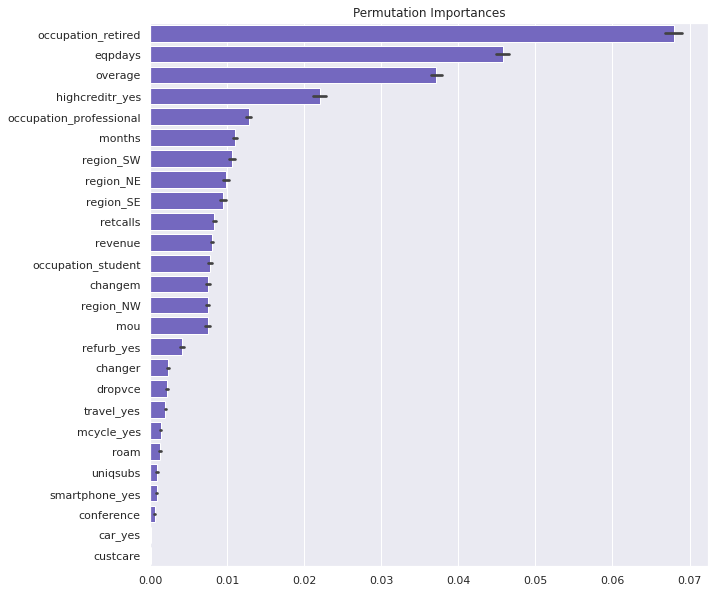

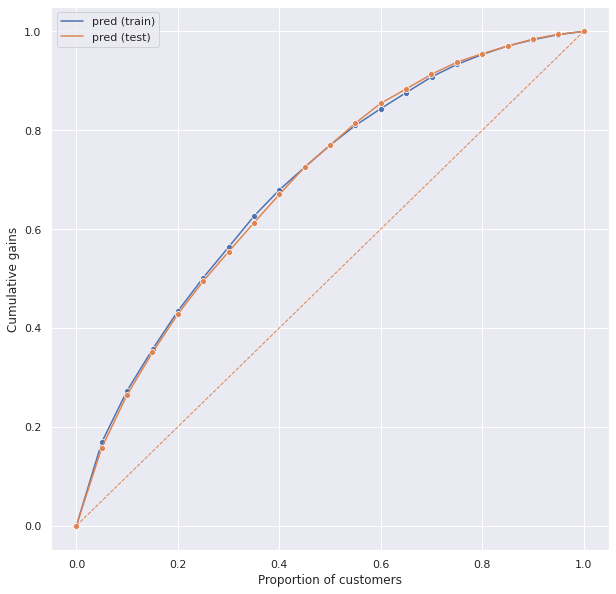

NN Train AUC: 0.699

NN Test AUC: 0.696



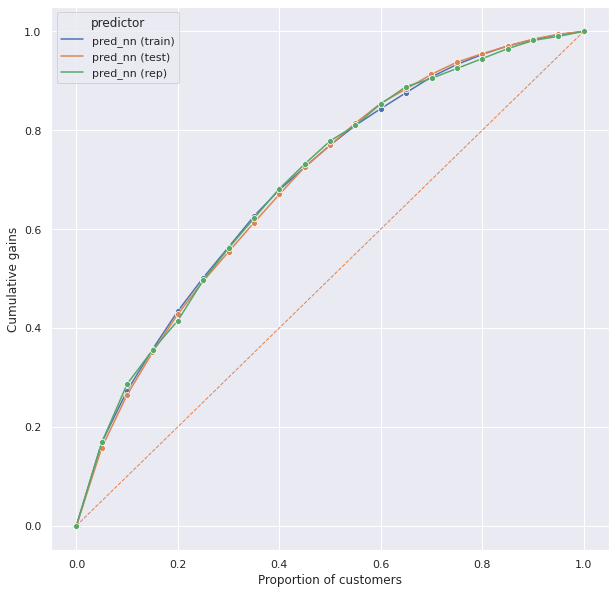

           pred  actualdiff
train  0.019966    0.000034
test   0.020064   -0.000064
rep    0.019953    0.000047


In [28]:
# run python code from another notebook
%run ./sub-notebooks/neural.ipynb


tree Model: AUC = 0.764046 at iteration 330


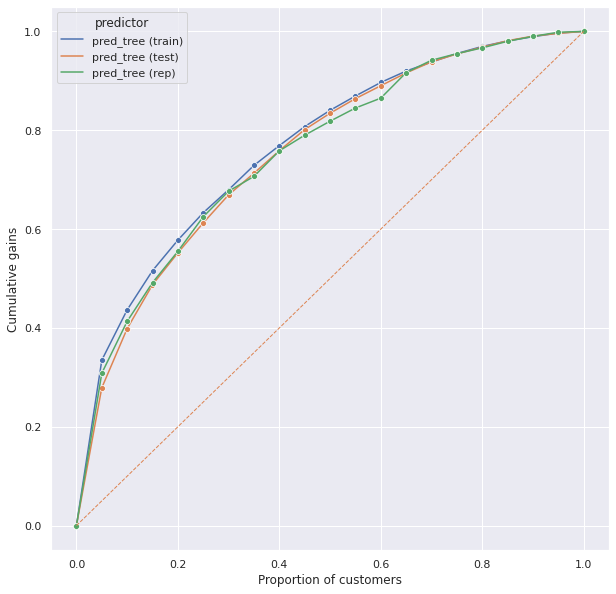

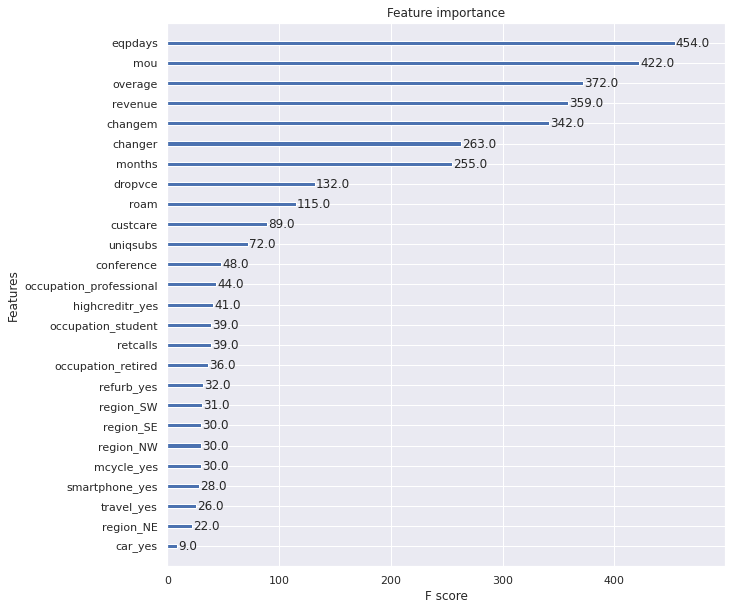

           pred  actualdiff
train  0.020003   -0.000003
test   0.021690   -0.001690
rep    0.021678   -0.001678


In [13]:
# run python code from another notebook
%run ./sub-notebooks/tree.ipynb

## Question answers

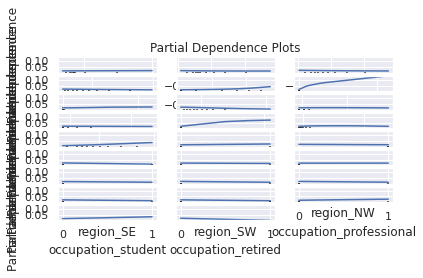

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.set_title("Partial Dependence Plots")
fig = PartialDependenceDisplay.from_estimator(clf, X_train, X_train.columns, ax=ax)

In [24]:
tree_df.groupby('eqpdays').pred_tree.agg('mean').sort_values(ascending=False)

eqpdays
1317.0    0.996570
1485.0    0.968861
1762.0    0.813420
1432.0    0.797330
1359.0    0.745427
            ...   
59.0      0.001307
22.0      0.001242
37.0      0.000667
1724.0    0.000647
119.0     0.000481
Name: pred_tree, Length: 1413, dtype: float32

In [25]:
X_sample.overage.min()

-0.4524763494072287

In [26]:
s_mobile_1m.overage.min()

0

In [30]:
nn_df_rep = nn_df_sample.copy()
nn_df_rep["p_overage0"] = clf.predict_proba(
    X_sample.assign(overage=X_sample.overage.min())
)[:, 1]
nn_df_rep.loc[nn_df_rep.overage > nn_df_rep.overage.min(), ["churn_yes", "p_overage0"]].agg(
    ["count", "mean"]
).round(4)



,churn_yes,p_overage0
count,16264.0000,16264.0000
mean,0.0243,0.0143


In [32]:
X_train.roam.describe()

count    6.825000e+05
mean    -7.864338e-16
std      5.000004e-01
min     -8.983951e-02
25%     -8.983951e-02
50%     -8.983951e-02
75%     -8.983951e-02
max      5.766329e+01
Name: roam, dtype: float64